In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches


# Training data preparation 

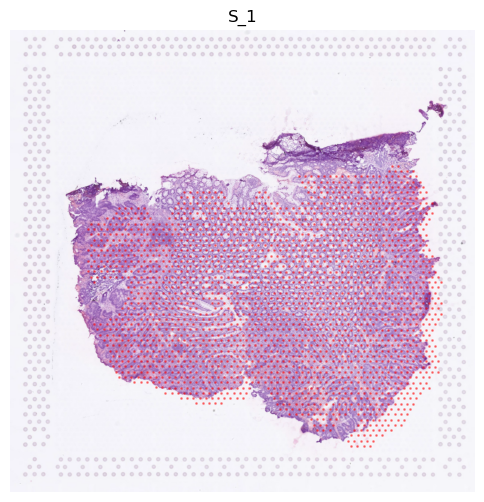

In [2]:
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [3]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

S_1
S_2
S_3
S_4
S_5
S_6


,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,1554,1297,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,0.020029,...,1.009572e-03,2.068237,0.121361,0.007344,0.000017,0.036891,0.035934,0.118937,0.001472,0.050057
1,462,1502,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,0.001711,...,6.918171e-04,0.014442,0.000238,0.024071,0.000023,0.217589,0.100662,0.004027,0.004122,0.049491
2,1488,1548,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,0.000114,...,9.577447e-05,0.149792,0.001401,0.000699,0.000009,0.024491,0.018810,0.004171,0.000425,0.015348
3,1725,1182,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,0.010154,...,1.964150e-03,0.142549,0.002036,0.047165,0.000022,0.180372,0.202981,0.003709,0.001845,0.116022
4,581,1113,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,0.000468,...,7.189078e-05,0.005920,0.000048,0.006359,0.000585,0.052661,0.032168,0.000107,0.000107,0.013103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,1055,701,0.047236,0.112721,0.052490,0.002092,0.000913,0.393805,0.045220,0.013414,...,7.530558e-03,0.559967,0.154793,0.133587,0.000013,0.051041,0.113100,0.003147,0.004971,0.128265
2193,1225,862,0.070764,0.119310,0.193938,0.001239,0.003851,0.588956,0.037731,0.004072,...,3.219223e-02,0.667076,0.094247,0.136623,0.000009,0.050518,0.119685,0.027743,0.016413,0.287171
2194,765,1479,0.194491,0.048068,0.150061,0.002978,0.119206,0.000213,0.005332,0.000078,...,2.628421e-04,0.000273,0.000022,0.000027,0.000042,0.029386,0.019977,0.000039,0.000119,0.006778
2195,607,1525,0.002968,0.151899,0.015931,0.000071,1.354983,0.000152,0.019254,0.001267,...,1.377452e-03,0.003754,0.001420,0.088000,0.000536,0.073240,0.113631,0.009040,0.000090,0.025716


In [5]:
def extract_tile(slide_img, x, y, tile_size=224):
    half = tile_size // 2
    x1, x2 = x - half, x + half
    y1, y2 = y - half, y + half
    tile = slide_img[y1:y2, x1:x2]  # shape: (224, 224, 3)
    return tile

import numpy as np

def pad_tile(tile, target_size=64, mode='white'):
    """
    將 tile padding 成指定大小。
    
    - tile: numpy array, shape (H, W, C)
    - target_size: 目標邊長 (e.g., 64)
    - mode: 'constant' (zero padding), 'reflect', 或 'white' (255 padding)
    """
    h, w, c = tile.shape
    assert h <= target_size and w <= target_size, "Tile size must be <= target size"
    
    pad_h = target_size - h
    pad_w = target_size - w

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    if mode == 'constant':
        value = 0
    elif mode == 'white':
        value = 1
    elif mode == 'reflect':
        return np.pad(tile, 
                      ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                      mode='reflect')
    else:
        raise ValueError("Unsupported padding mode.")

    padded_tile = np.pad(tile,
                         ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                         mode='constant',
                         constant_values=value)
    return padded_tile



def get_spots_in_tile(df, center_x, center_y, tile_size):
    half = tile_size // 2
    x_min, x_max = center_x - half, center_x + half
    y_min, y_max = center_y - half, center_y + half

    df_in_tile = df[
        (df['x'] >= x_min) & (df['x'] <= x_max) &
        (df['y'] >= y_min) & (df['y'] <= y_max)
    ].copy()

    df_in_tile = df_in_tile[
        ~((df_in_tile['x'] == center_x) & (df_in_tile['y'] == center_y))
    ]

    return df_in_tile

    return df_in_tile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_tile_with_spots_v2(
    slide_image,
    spot_df=None,
    center_x=None,
    center_y=None,
    tile_size=None,
    stride=None,
    grid_size=None,
    spot_radius_px=15,
    ax=None,
    title=None,
    show_legend=False
):
    """
    萬用版 patch 可視化工具：
    - 若有提供 center_x, center_y, tile_size → 畫 tile
    - 若沒有這些參數 → 畫整張 slide + 所有 spots
    """

    H, W, _ = slide_image.shape

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    if center_x is not None and center_y is not None and tile_size is not None:
        if stride is None:
            stride = tile_size

        if grid_size:
            full_tile_size = tile_size + stride * (grid_size - 1)
        else:
            full_tile_size = tile_size

        def extract_tile(slide_img, x, y, total_size):
            x, y = int(x), int(y)
            half = total_size // 2
            x1, x2 = max(0, x - half), min(W, x + half)
            y1, y2 = max(0, y - half), min(H, y + half)
            return slide_img[y1:y2, x1:x2]

        tile = extract_tile(slide_image, center_x, center_y, full_tile_size)
        ax.imshow(tile)

        center_px = full_tile_size // 2
        ax.scatter(center_px, center_px, c='red', s=40, label='Center Spot')

        circle = patches.Circle(
            (center_px, center_px),
            spot_radius_px,
            linewidth=1.5,
            edgecolor='yellow',
            facecolor='none'
        )
        ax.add_patch(circle)

        if spot_df is not None:
            for _, neighbor in spot_df.iterrows():
                dx = int(neighbor['x']) - center_x
                dy = int(neighbor['y']) - center_y
                tile_x = center_px + dx
                tile_y = center_px + dy
                ax.scatter(tile_x, tile_y, c='orange', s=20)

        if grid_size:
            for row in range(grid_size):
                for col in range(grid_size):
                    x0 = col * stride
                    y0 = row * stride
                    rect = patches.Rectangle(
                        (x0, y0),
                        tile_size, tile_size,
                        linewidth=1,
                        edgecolor='blue',
                        facecolor='none',
                        linestyle='--'
                    )
                    ax.add_patch(rect)

    else:
        # 沒有 tile → 直接畫整張 slide 圖
        ax.imshow(slide_image)
        if spot_df is not None:
            ax.scatter(spot_df['x'], spot_df['y'], c='orange', s=10, label='Spots')

    ax.axis('off')
    if title:
        ax.set_title(title)
    if show_legend:
        ax.legend(loc='upper right')



def apply_circular_mask(tile, background_value=1):
    """
    將 tile（H, W, C）遮罩成圓形，非圓區域設為 background_value。
    預設背景為白色（255）
    """
    h, w, c = tile.shape
    assert h == w, "Tile must be square"

    radius = h // 2
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - radius)**2 + (Y - radius)**2)
    mask = dist_from_center <= radius

    # 擴展 mask 至 RGB 通道
    mask = np.expand_dims(mask, axis=-1)  # shape (H, W, 1)
    
    if background_value == 0:
        bg_color = np.zeros_like(tile)
    else:
        bg_color = np.full_like(tile, background_value)
    
    return tile * mask + bg_color * (1 - mask)



## calculate tile_size

In [6]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

train_spacing_per_slide = {}

for slide_id, df in train_spot_tables.items():
    coords = df[['x', 'y']].values
    if len(coords) < 2:
        print(f"⚠️ Slide {slide_id} has less than 2 spots, skipping.")
        continue

    dist_matrix = squareform(pdist(coords))
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = dist_matrix.min(axis=1)
    mean_spacing = min_dists.mean()

    train_spacing_per_slide[slide_id] = mean_spacing
    print(f"📏 {slide_id}: 平均 spot 間距 = {mean_spacing:.2f} pixels")




📏 S_1: 平均 spot 間距 = 25.90 pixels
📏 S_2: 平均 spot 間距 = 25.91 pixels
📏 S_3: 平均 spot 間距 = 25.20 pixels
📏 S_4: 平均 spot 間距 = 25.02 pixels
📏 S_5: 平均 spot 間距 = 25.01 pixels
📏 S_6: 平均 spot 間距 = 25.24 pixels


## show image

In [7]:
tile_size = round(max(train_spacing_per_slide.values()))  # → round(77.7) → 78
print(f"\n🔍 所有 slide tile size {tile_size} pixels")

df = train_spot_tables['S_1']
row = df.iloc[0]

x = int(row['x'])
y = int(row['y'])

# 取得tile範圍內的spot們
neighbors_df = get_spots_in_tile(df, x, y, tile_size=128)

print(f"Found {len(neighbors_df)} spots in this tile.")
print(neighbors_df[['x', 'y']])
print(x,y)


🔍 所有 slide tile size 26 pixels
Found 21 spots in this tile.
         x     y
237   1580  1297
291   1541  1320
292   1606  1251
342   1501  1342
350   1514  1274
413   1554  1251
500   1580  1251
537   1514  1320
594   1580  1342
628   1528  1297
737   1606  1342
739   1606  1297
860   1554  1342
887   1501  1251
1212  1501  1297
1388  1567  1320
1839  1528  1342
1875  1593  1274
2018  1528  1251
2132  1541  1274
2173  1593  1320
1554 1297


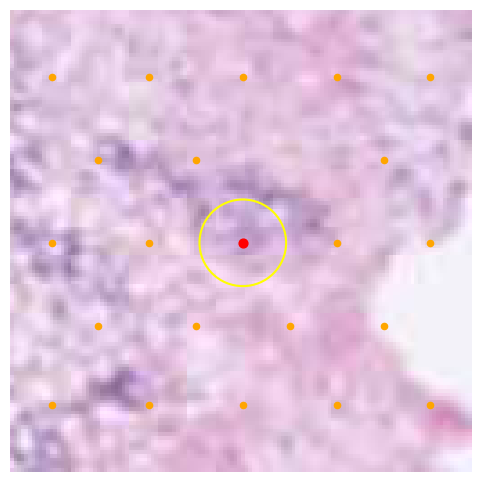

In [88]:


plot_tile_with_spots_v2(
    slide_image=image,
    spot_df=neighbors_df,
    center_x=x,
    center_y=y,
    tile_size=128,
    #grid_size=3,
    spot_radius_px=12
)


## Start tiling

In [10]:
from scipy.spatial import KDTree
def compute_edge_index(coords, radius=64):
    """
    計算每個 batch 的 edge_index（鄰接關係）
    同時顯示每個點的鄰居數量
    """
    kdtree = KDTree(coords)
    edge_list = []
    
    # 用來統計每個點的鄰居數量
    neighbor_counts = []
    
    for i, coord in enumerate(coords):
        neighbors = kdtree.query_ball_point(coord, r=radius)  # 查找半徑為 radius 的鄰居
        
        # 計算當前點的鄰居數量
        neighbor_counts.append(len(neighbors))
        
        # 將所有鄰居添加到 edge_list 中
        for j in neighbors:
            if i != j:
                edge_list.append([i, j])

    # 顯示每個點的鄰居數量
    
            # 將邊列表轉換為 PyG 格式
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    return edge_index


In [12]:
import h5py
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
train_S_tiles = []
train_M_tiles = []
train_L_tiles = []
train_labels = []
train_meta_info = []
train_total_node = 0
train_edge_indices = []
normal_coords = []

with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue

        image = train_images[slide_id][()]  # H x W x 3
        df = train_spot_tables[slide_id]

        
        # 提取 (x, y) 座標並進行標準化
        coords = df[['x', 'y']].values
        scaler = MinMaxScaler()
        coords_normalized = scaler.fit_transform(coords)  # 將座標標準化到 [0, 1] 範圍內
                # 儲存標準化後的 (x, y) 座標
        df[['x_normalized', 'y_normalized']] = coords_normalized
        
        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])

            train_S_tile = extract_tile(image, x, y, tile_size=26)
            train_S_tile = pad_tile(train_S_tile, target_size=32, mode='white')
            train_S_tile = apply_circular_mask(train_S_tile, background_value=1) 
            train_M_tile = extract_tile(image, x, y, tile_size=64)
            train_L_tile = extract_tile(image, x, y, tile_size=128)
            
            neighbors_df = get_spots_in_tile(df, x, y, tile_size=128)
            neighbor_coords = neighbors_df[['x', 'y']].values
            edge_index = compute_edge_index(neighbor_coords, radius=64) # should be half tile_size
            train_total_node += len(neighbor_coords)  # 計算總節點數量
            label = row.iloc[2:-2].values.astype(np.float32)

            train_S_tiles.append(train_S_tile)
            train_M_tiles.append(train_M_tile)
            train_L_tiles.append(train_L_tile)  # ✅ 存入
            train_labels.append(label)
            train_meta_info.append((slide_id, x, y))
            train_edge_indices.append(edge_index)  # 儲存邊索引
            normal_coords.append((row['x_normalized'], row['y_normalized']))  # 儲存標準化後的 (x, y) 座標

21
9
22
22
22
22
21
22
22
18
21
22
13
19
22
22
22
22
22
20
22
22
21
22
22
19
18
22
22
22
21
22
22
22
19
21
22
13
20
22
22
11
22
22
22
22
22
16
22
22
22
22
22
21
9
22
22
22
22
22
22
22
18
22
22
9
22
22
22
22
22
22
22
22
21
22
22
22
22
22
22
22
21
22
22
12
18
22
22
22
20
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
21
18
18
21
14
22
18
22
22
22
22
18
22
15
22
22
22
22
12
22
22
22
22
22
22
22
21
21
18
22
22
22
22
22
8
22
22
15
12
17
20
22
16
22
22
22
22
21
13
22
22
18
22
22
22
22
21
22
22
15
19
22
22
22
22
21
22
22
22
22
22
22
22
22
22
22
22
20
22
11
15
22
15
14
21
22
22
22
20
22
22
20
22
22
22
8
21
22
13
12
21
22
17
22
21
22
22
22
22
22
22
18
22
22
22
22
21
22
12
16
22
22
22
22
22
22
18
15
22
21
21
21
22
22
22
22
22
12
22
22
22
18
22
22
22
14
22
18
22
22
22
21
22
22
22
22
14
22
22
22
22
20
14
16
21
14
13
22
22
22
17
22
22
22
22
22
22
16
22
22
14
19
22
21
21
22
21
22
22
17
13
22
21
20
22
22
22
21
20
22
22
20
22
22
21
21
22
18
22
22
15
21
22
15
22
22
22
22
12
10
22
14
22
13
22
22
22


In [14]:
train_total_nodes = []
for i in range(len(train_S_tiles)):
    train_total_nodes.append(train_total_node)

### Validate the cut

Found 0 spots in S tile.
Found 6 spots in M tile.
Found 18 spots in L tile.
Slides: S_2, (1506, 1418)


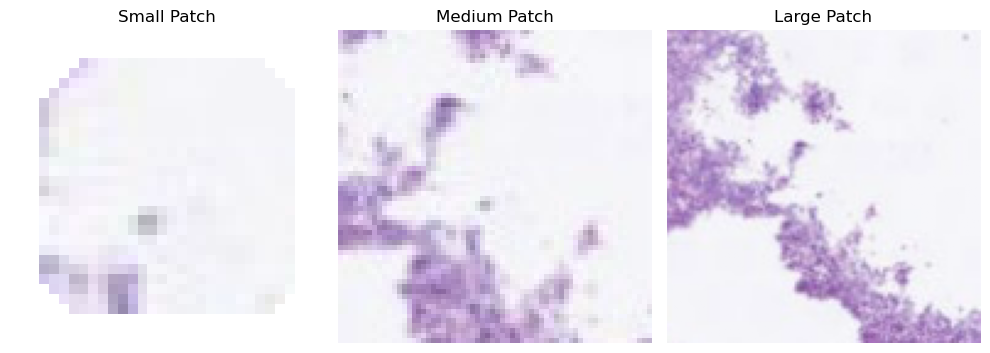

🧬 C1~C35 Expression Comparison:
Index         Original    SubTiles      Δ Diff
----------------------------------------
C1             2.283      2.283      0.000
C2             0.037      0.037      0.000
C3             1.951      1.951      0.000
C4             0.419      0.419      0.000
C5             0.221      0.221      0.000
C6             0.000      0.000      0.000
C7             0.014      0.014      0.000
C8             0.000      0.000      0.000
C9             0.000      0.000      0.000
C10            0.000      0.000      0.000
C11            0.000      0.000      0.000
C12            0.002      0.002      0.000
C13            0.000      0.000      0.000
C14            0.001      0.001      0.000
C15            0.000      0.000      0.000
C16            0.005      0.005      0.000
C17            0.007      0.007      0.000
C18            0.237      0.237      0.000
C19            0.006      0.006      0.000
C20            0.110      0.110      0.000
C21            0.007

In [64]:
import random

# 隨機抽一筆資料（從全體 tiles 中）
i = random.randint(0, len(train_meta_info) - 1)

# 取對應的 sub-tiles 與 label
train_S_tile = train_S_tiles[i]
train_M_tile = train_M_tiles[i]
train_L_tile = train_L_tiles[i]
label = train_labels[i]
slide_id, x, y = train_meta_info[i]  # 👈 slide 來源、spot 座標


# 找原始 label（可選）
row = train_spot_tables[slide_id]
row_match = row[(row['x'] == x) & (row['y'] == y)]
if len(row_match) == 0:
    print("⚠️ 找不到對應的 spot")
    label_gt = label  # fallback
else:
    label_gt = row_match.iloc[0].iloc[2:].values.astype(np.float32)


# 取得tile範圍內的spot們
S_neighbors_df = get_spots_in_tile(row, x, y, tile_size=26)
M_neighbors_df = get_spots_in_tile(row, x, y, tile_size=64)
L_neighbors_df = get_spots_in_tile(row, x, y, tile_size=128)

print(f"Found {len(S_neighbors_df)} spots in S tile.")
print(f"Found {len(M_neighbors_df)} spots in M tile.")
print(f"Found {len(L_neighbors_df)} spots in L tile.")


# 執行視覺化比對
print(f"Slides: {slide_id}, ({x}, {y})")

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

plot_tile_with_spots_v2(
    train_S_tile, spot_radius_px=13,
    ax=axes[0], title="Small Patch"
)

plot_tile_with_spots_v2(
    train_M_tile, spot_radius_px=32,
    ax=axes[1], title="Medium Patch"
)

plot_tile_with_spots_v2(
    train_L_tile, spot_radius_px=64,
    ax=axes[2], title="Large Patch"
)

plt.tight_layout()
plt.show()


if label_gt is not None and label is not None:
    print("🧬 C1~C35 Expression Comparison:")
    print(f"{'Index':<10}{'Original':>12}{'SubTiles':>12}{'Δ Diff':>12}")
    print("-" * 40)
    for i in range(35):
        ori = label_gt[i]
        sub = label[i]
        diff = sub - ori
        print(f"C{i+1:<8} {ori:>10.3f} {sub:>10.3f} {diff:>10.3f}")

## Transfer into training dataset 

In [68]:
## Make sure I have all the data
total_spots = sum(len(df) for df in train_spot_tables.values())
print(f"Total number of spots across all slides: {total_spots}")

print(f"The spots in our preprocessing datasets: {len(train_S_tiles)}")

Total number of spots across all slides: 8349
The spots in our preprocessing datasets: 8349


In [15]:
import torch


torch.save({
    'S_tiles': train_S_tiles,
    'M_tiles': train_M_tiles,
    'L_tiles': train_L_tiles,
    'labels': train_labels,
    'meta_info': train_meta_info,
    'normal_coords': normal_coords,
    'edge_indices': train_edge_indices,
    'total_nodes': train_total_nodes,
}, "../SML_train_dataset.pt")

# Test data preparation

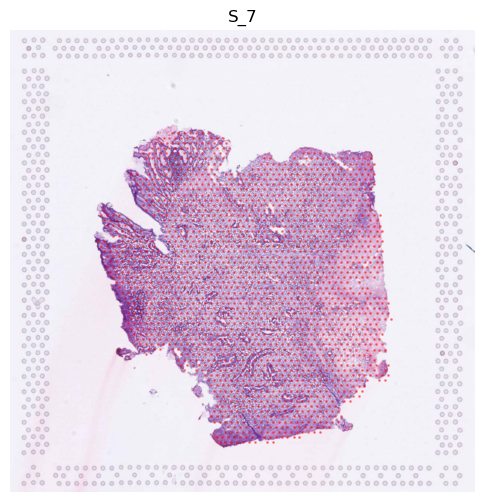

In [16]:
# Visualize Test slide ('S_7')
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    test_spots = h5file["spots/Test"]
    
    sample = 'S_7'
    image = np.array(test_images[sample])
    spots = np.array(test_spots[sample])
    x, y = spots["x"], spots["y"]

    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [17]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    print(test_spots.keys())
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

<KeysViewHDF5 ['S_7']>


,x,y,Test_Set
0,1499,1260,2
1,1435,1503,2
2,558,1082,2
3,736,1304,1
4,1257,1592,1
...,...,...,...
2083,736,639,2
2084,1016,684,2
2085,1181,839,2
2086,735,1436,1


In [18]:
coords = test_spot_table[['x', 'y']].values
# 計算距離矩陣（所有 spot 之間）
dist_matrix = squareform(pdist(coords))  # shape = (N, N)

# 把對角線設為無限大（自己對自己不算）
np.fill_diagonal(dist_matrix, np.inf)

# 取得每個 spot 最近的一個鄰居距離
min_dists = dist_matrix.min(axis=1)

# 算平均距離
mean_spacing = min_dists.mean()

print(f"平均每個 spot 間距：約 {mean_spacing:.2f} pixels")

平均每個 spot 間距：約 25.01 pixels


In [19]:
import h5py
import numpy as np

test_S_tiles = []
test_M_tiles = []
test_L_tiles = []
test_labels = []
test_meta_info = []
test_coords_normalized = []
test_edge_indices=[]
test_total_node = 0

with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    slide_ids = list(test_images.keys())  # e.g., only ['S_7']

    for slide_id in slide_ids:
        image = test_images[slide_id][()]  # 讀出唯一一張 test image

        # ✅ test_spot_table 是單一 DataFrame，不是 dict！
        df = test_spot_table  # 不用 [slide_id]！
        scaler = MinMaxScaler()
        coords_normalized = scaler.fit_transform(coords) 
        df[['x_normalized', 'y_normalized']] = coords_normalized
        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])

            test_S_tile = extract_tile(image, x, y, tile_size=26)
            test_S_tile = pad_tile(test_S_tile, target_size=32, mode='white')
            test_S_tile = apply_circular_mask(test_S_tile, background_value=1) 
            test_M_tile = extract_tile(image, x, y, tile_size=64)
            test_L_tile = extract_tile(image, x, y, tile_size=128)

            neighbors_df = get_spots_in_tile(df, x, y, tile_size=128)
            neighbor_coords = neighbors_df[['x', 'y']].values
            edge_index = compute_edge_index(neighbor_coords, radius=64) # should be half tile_size
            test_total_node += len(neighbor_coords)
            
            label = row.iloc[2:-2].values.astype(np.float32)
            test_S_tiles.append(test_S_tile)
            test_M_tiles.append(test_M_tile)
            test_L_tiles.append(test_L_tile)  # ✅ 存入
            test_labels.append(label)
            test_edge_indices.append(edge_index)  # 儲存邊索引
            test_meta_info.append((slide_id, x, y))
            test_coords_normalized.append((row['x_normalized'], row['y_normalized']))
            
print('finished')   # 儲存標準化後的 (x, y) 座標

finished


In [20]:
test_total_nodes=[]
for i in range(len(test_S_tiles)):
    test_total_nodes.append(test_total_node)

Slides: S_7


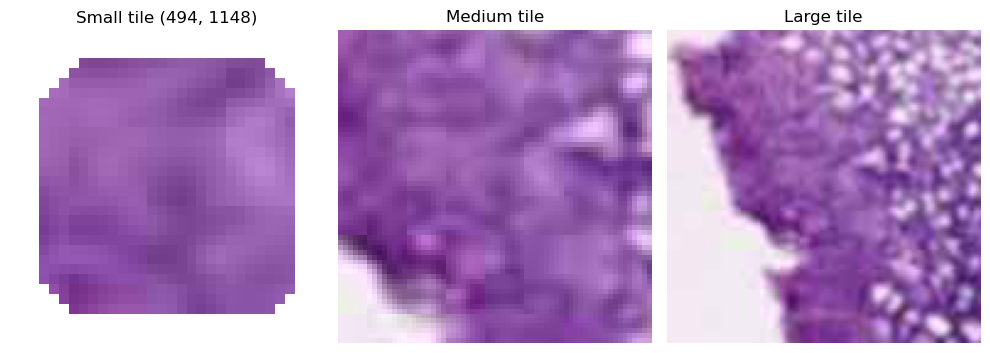

In [21]:
import random

# 隨機抽一筆資料（從全體 tiles 中）
i = random.randint(0, len(test_meta_info) - 1)

# 取對應的 sub-tiles 與 label
test_S_tile = test_S_tiles[i]
test_M_tile = test_M_tiles[i]
test_L_tile = test_L_tiles[i]
label = test_labels[i]
slide_id, x, y = test_meta_info[i]  # 👈 slide 來源、spot 座標


# 找原始 label（可選）
row = test_spot_table  # 不用 [slide_id]！
row_match = row[(row['x'] == x) & (row['y'] == y)]
if len(row_match) == 0:
    print("⚠️ 找不到對應的 spot")
    label_gt = label  # fallback
else:
    label_gt = row_match.iloc[0].iloc[2:].values.astype(np.float32)

# 執行視覺化比對
print(f"Slides: {slide_id}")

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(test_S_tile)
axes[0].set_title(f"Small tile ({x}, {y})")
axes[0].axis("off")

axes[1].imshow(test_M_tile)
axes[1].set_title("Medium tile")
axes[1].axis("off")
axes[2].imshow(test_L_tile)
axes[2].set_title("Large tile")
axes[2].axis("off")
plt.tight_layout()
plt.show()

In [105]:
## Make sure I have all the data     

print(f"Total number of spots across all slides: {len(test_spot_table)}")

print(f"The spots in our preprocessing datasets: {len(test_edge_indices)}")

Total number of spots across all slides: 2088
The spots in our preprocessing datasets: 2088


In [22]:
torch.save({
    'S_tiles': test_S_tiles,
    'M_tiles': test_M_tiles,
    'L_tiles': test_L_tiles,
    'labels': test_labels,
    'meta_info': test_meta_info,
    'normal_coords': test_coords_normalized,
    'edge_indices': test_edge_indices,
    'total_nodes': test_total_nodes,
}, "../SML_test_dataset.pt")